# Project 11: Index Tracking and Forward Testing (US Stocks)

## Importing the Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [188]:
dji = pd.read_csv('dji.csv', parse_dates = ['Date'], index_col = 'Date').loc['2010-01-01':,]
dji = dji.loc[:, 'Close'].to_frame()

In [189]:
stocks = pd.read_csv('const_prices.csv', parse_dates = ['Date'], index_col = 'Date')
stocks = stocks.loc['2010-01-01':,]

In [190]:
data = dji.merge(stocks, how = 'left', left_index = True, right_index = True)

In [191]:
data.rename(columns = {'Close': 'DJI'}, inplace = True)

In [192]:
more_info = pd.read_csv('const.csv')

## Transforming the Data

In [193]:
df = data.copy()

In [194]:
norm = df.div(df.iloc[0]).mul(100)

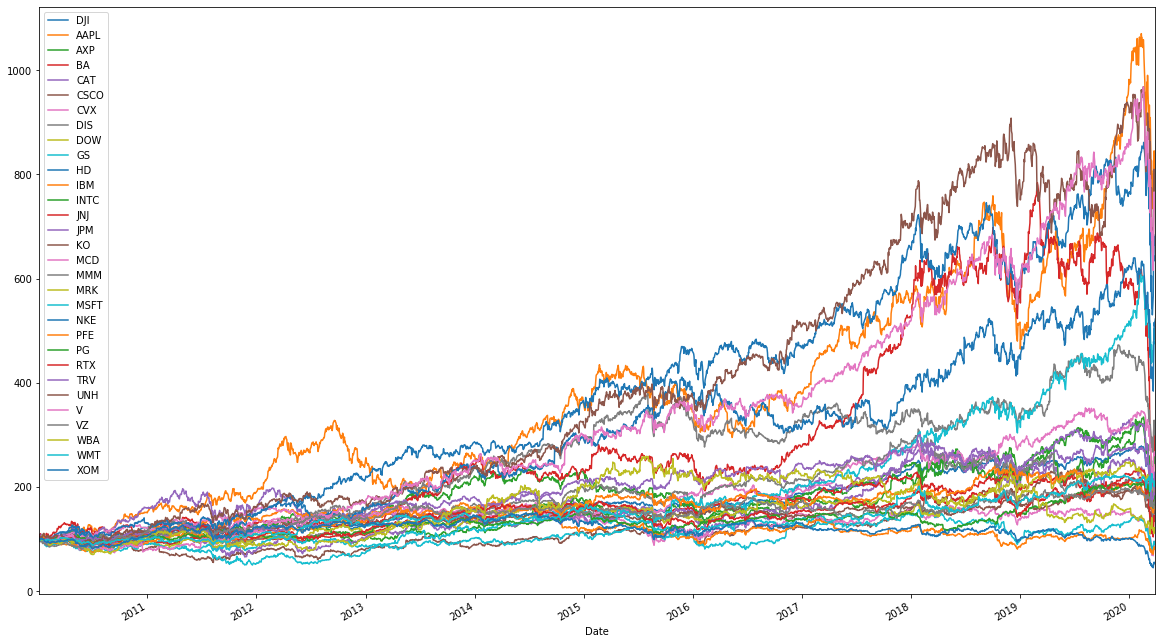

In [195]:
norm.plot(figsize = (20,12))

In [196]:
ret = norm.pct_change()

In [197]:
def summary_ann(returns):
    summary = returns.agg(['mean', 'std']).T
    summary['Return'] = summary['mean'] * 265
    summary['Risk'] = summary['std'] * np.sqrt(265)
    summary.drop(columns = ['mean', 'std'], inplace = True)
    return summary

In [198]:
annual_ret = summary_ann(ret)

In [199]:
annual_ret = annual_ret.merge(more_info[['Company','Ticker']], how = 'left', left_index = True, right_on = 'Ticker')

In [200]:
annual_ret.set_index('Company', inplace = True)

## Explanatory Data Analysis

In [201]:
summary2 = annual_ret.drop(index = 'Dow Inc.')

In [202]:
summary2.rename({np.nan : 'Dow Jones'}, inplace = True)

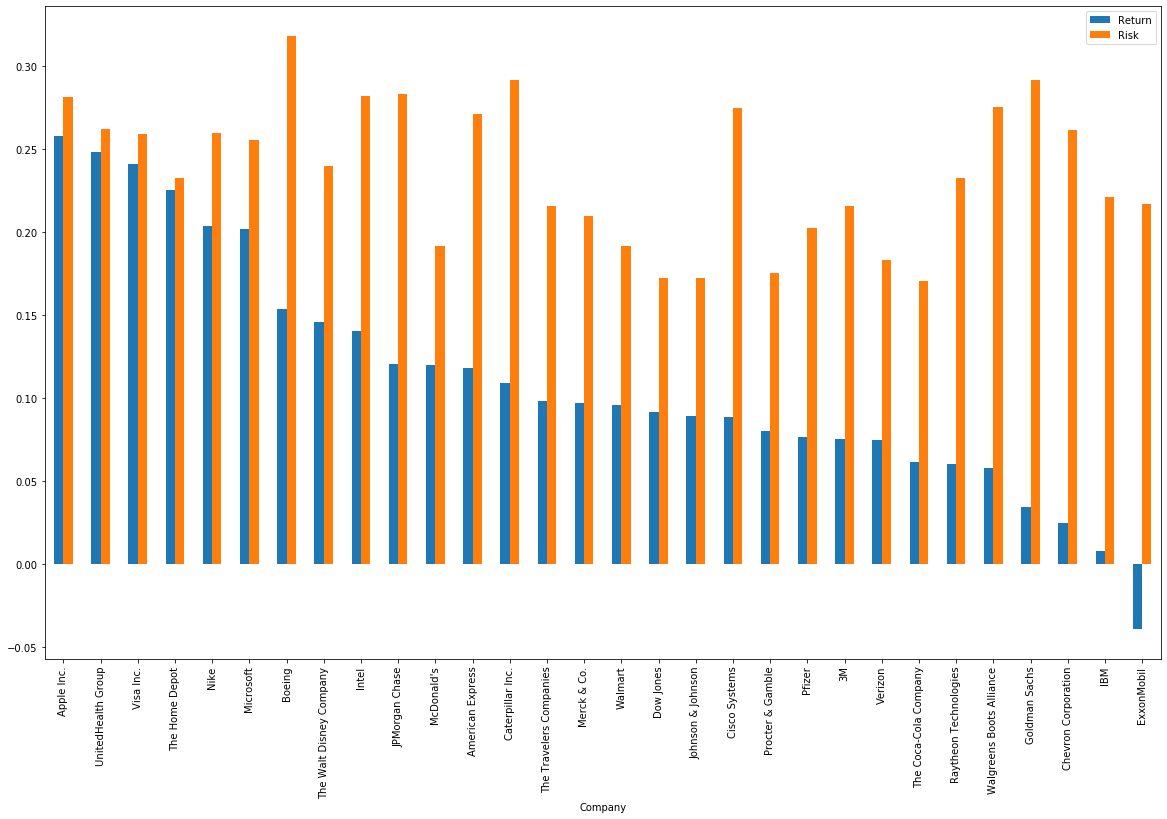

In [203]:
summary2.sort_values('Return', ascending = False).plot(kind = 'bar', figsize = (20,12))

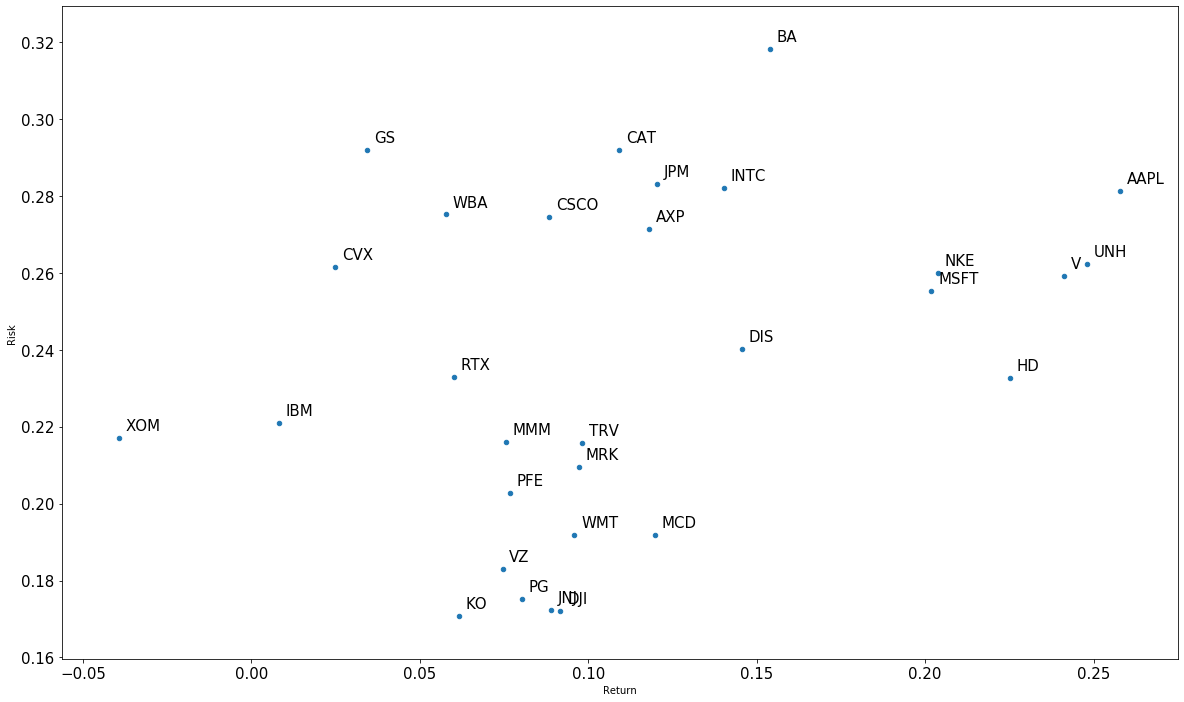

In [204]:
summary2.plot( 'Return', 'Risk', kind = 'scatter', figsize = (20,12), fontsize = 15)
for i in summary2.index:
    plt.annotate(summary2.loc[i,'Ticker'], (summary2.loc[i,'Return']+0.002, summary2.loc[i,'Risk']+0.002), fontsize = 15)

In [205]:
ret_corr = ret.corr()

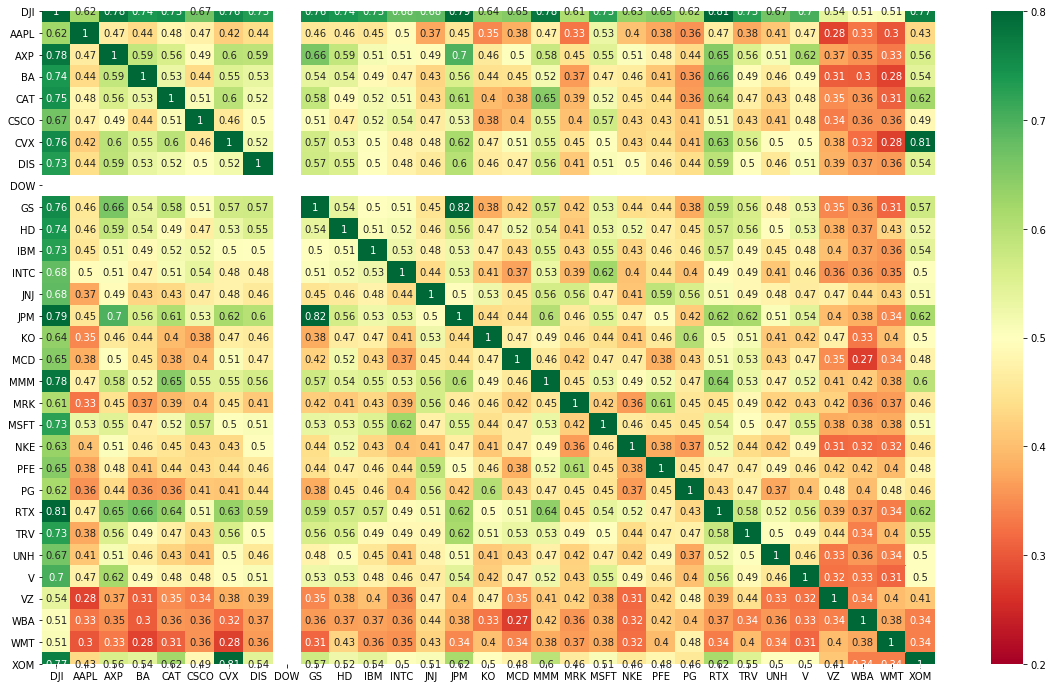

In [206]:
plt.figure(figsize = (20,12))
sns.heatmap(ret_corr, cmap = 'RdYlGn', annot = True, vmin = 0.2, vmax = 0.8)

## Index Tracking - an Introduction

Plan: Track the DJI with only __10 Stocks__ (Tracking Portfolio).

Criteria to select Tracking Portfolio: Those 10 Stocks with the __lowest individual Tracking Error__ (TE) in the Training/Fitting Period.

- Training/Fitting Period: 2017 & 2018
- (Forward) Testing Period: 2019

Once we have identified the 10 Tracking Stocks we need to find their __optimal weights__ in the Tracking Portfolio that __minimize TE__.

In [207]:
train = df.loc['2017':'2018',].copy()

In [208]:
train.drop(columns = 'DOW', inplace = True)

In [209]:
train_norm = train.div(train.iloc[0]).mul(100)

In [210]:
train_ret = ret.loc['2017':'2018'].copy()

In [211]:
train_ret.drop(columns = 'DOW', inplace = True)

In [212]:
ret_diff = train_ret.sub(train_ret.DJI, axis = 0)

In [213]:
ret_diff

,DJI,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.0,-0.003180,0.011114,0.002257,0.007449,0.004559,-0.004755,0.011817,0.002824,-0.004314,...,0.009980,-0.004602,0.005009,-0.018446,0.002781,0.012940,0.016451,-0.003613,-0.012685,0.000950
2017-01-04,0.0,-0.004157,0.009039,0.007474,-0.007507,-0.017445,-0.003293,0.009783,0.003420,0.005822,...,0.005750,0.000525,-0.002406,-0.008414,-0.000189,0.005138,-0.004137,-0.002797,0.002788,-0.014040
2017-01-05,0.0,0.007235,-0.010177,0.002717,-0.003942,0.004475,-0.002179,0.001591,-0.005295,-0.009658,...,0.011762,0.008777,0.006207,-0.013817,0.003817,0.013878,0.004351,0.002752,0.004322,-0.012757
2017-01-06,0.0,0.007906,-0.001250,-0.000785,-0.002812,-0.001253,-0.007248,0.011659,0.011593,-0.006005,...,-0.007110,-0.003595,0.007535,-0.003749,-0.001824,0.010570,-0.028498,-0.002399,-0.016968,-0.003807
2017-01-09,0.0,0.012987,0.008996,-0.001075,-0.003373,0.002174,-0.004731,-0.001861,-0.004379,0.009669,...,0.003529,-0.003581,-0.005501,-0.004205,0.000996,-0.001767,-0.007062,-0.002791,0.010420,-0.012669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,0.0,0.003226,0.009063,-0.005015,0.003116,-0.008414,-0.001799,-0.008033,0.005983,0.014519,...,-0.003812,-0.010583,-0.009702,-0.000453,0.006444,0.008740,-0.004949,-0.000635,0.014065,-0.009214
2018-12-26,0.0,0.020576,-0.001354,0.017362,0.016935,0.004524,0.013527,0.004763,-0.007761,0.014275,...,-0.009402,-0.018596,-0.011143,-0.009537,-0.005156,0.019981,-0.023644,-0.012150,0.003638,-0.002067
2018-12-27,0.0,-0.017870,-0.002429,-0.001155,0.003929,-0.001020,0.006591,-0.004861,0.003841,0.000742,...,0.004263,0.010042,-0.013739,0.001421,-0.000614,0.002287,0.001661,-0.001930,0.001671,-0.007010


In [214]:
abs(ret_diff.sum(axis = 0)).sort_values()[1:11]

JPM    0.023529
KO     0.035574
JNJ    0.039834
PG     0.069903
MMM    0.082348
VZ     0.096330
HD     0.098161
DIS    0.099598
AXP    0.105599
MRK    0.109571
dtype: float64

In [215]:
tracking_stocks = ret_diff.agg(['mean', 'std']).T.sort_values(by = 'std')[1:10]

## Selecting the Tracking Stocks

In [216]:
def tracking_ann(returns):
    summary = returns.agg(['mean', 'std']).T
    summary['Premium'] = summary['mean']*252
    summary['TE'] = summary['std']*np.sqrt(252)
    summary.drop(columns = ['mean', 'std'], inplace = True)
    return summary

In [217]:
tracking_stocks = tracking_ann(ret_diff).sort_values(by = 'TE')[:11]

In [218]:
norm_track = train_norm.loc[:, tracking_stocks.index]
norm_track

,DJI,MMM,JPM,PFE,V,AXP,RTX,KO,HD,XOM,TRV
Date,,,,,,,,,,,
2017-01-03,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2017-01-04,100.303798,100.151645,99.633154,100.878791,100.817612,101.207702,100.063159,99.641154,100.886012,98.899769,99.462364
2017-01-05,100.088168,99.809044,98.716035,101.848487,101.999995,99.960187,100.469184,99.880385,99.694733,97.425463,97.874277
2017-01-06,100.412645,100.101091,98.727501,101.454544,103.408804,100.159260,101.551928,99.856465,99.419255,97.370448,97.824644
2017-01-09,100.028273,99.561922,98.796282,101.424246,102.830189,100.676844,100.604537,98.851676,100.000000,95.764112,97.038874
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,109.609006,100.320130,105.628793,122.878786,153.119501,118.779034,92.086978,109.952153,117.742538,72.076139,93.159633
2018-12-26,115.072556,104.611059,110.008019,127.848481,163.811315,124.538817,95.650995,112.296649,125.292236,75.519859,96.914803
2018-12-27,116.382154,107.104742,111.246128,129.848480,166.050308,125.653619,95.425433,113.708133,126.811116,75.849932,98.155498


In [219]:
norm_track = norm_track.drop(columns = 'DJI')

# Index Tracking - A simple Tracking Portfolio

In [220]:
eweights = np.full(10,1/10)

In [221]:
train_ret.loc[:,norm_track.columns].dot(eweights)

Date
2017-01-03    0.007562
2017-01-04    0.001641
2017-01-05   -0.003983
2017-01-06    0.002168
2017-01-09   -0.004350
                ...   
2018-12-24   -0.027788
2018-12-26    0.045523
2018-12-27    0.011286
2018-12-28   -0.004372
2018-12-31    0.008403
Length: 502, dtype: float64

In [222]:
def port_ret(weights):
    return train_ret.loc[:,norm_track.columns].dot(weights)

In [223]:
def tracking_error(weights):
    return port_ret(weights).sub(train_ret.DJI).std()*np.sqrt(252)

In [224]:
tracking_error(eweights)

0.04120933686266798

In [225]:
ew_port = port_ret(eweights)[1:].add(1).cumprod().mul(100)

In [158]:
#norm_track['EW_Port'] = ew_port

In [160]:
#norm_track.iloc[0,-1] = 100

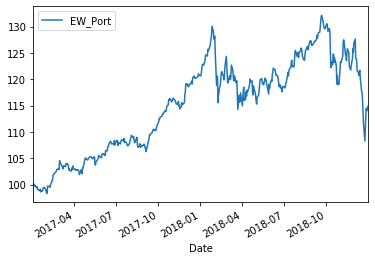

In [162]:
#norm_track[['EW_Port']].plot()

## Index Tracking - The optimal Tracking Portfolio

In [226]:
import scipy.optimize as sco

In [227]:
bnds = tuple((0,1) for x in range(10))


In [184]:
cons = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})

In [229]:
opt = sco.minimize(tracking_error, eweights, method = 'SLSQP', constraints = cons, bounds = bnds)

In [236]:
optimal_weights = pd.Series(opt['x'], index = tracking_stocks.index[1:])

In [237]:
optimal_weights

MMM    0.131020
JPM    0.144515
PFE    0.059847
V      0.167651
AXP    0.040286
RTX    0.100547
KO     0.076882
HD     0.109569
XOM    0.114603
TRV    0.055080
dtype: float64

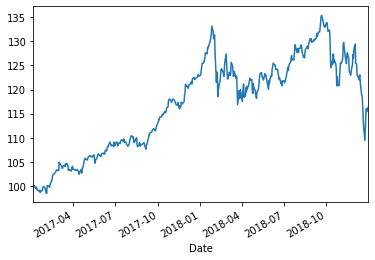

In [234]:
port_ret(opt['x'])[1:].add(1).cumprod().mul(100).plot()

## Forward Testing (Part 1)

In [249]:
tracked_stocks = tracking_stocks.index
tracked_stocks = tracked_stocks[1:]

In [282]:
tracked_stocks

Index(['MMM', 'JPM', 'PFE', 'V', 'AXP', 'RTX', 'KO', 'HD', 'XOM', 'TRV'], dtype='object')

In [252]:
def tracking_error_gen(data, tracked_stocks, weights, index, start, end):
    return data.loc[start:end, tracked_stocks].dot(weights).sub(ret.loc[start:end, index]).std()*np.sqrt(252)

In [253]:
tracking_error_gen(ret, tracked_stocks, optimal_weights, 'DJI', '2017-01-01','2018-12-31')

0.03796156173901624

In [266]:
def visual(data, tracked_stocks, weights, index, start, end):
    track = data.loc[start:end, tracked_stocks].dot(weights).add(1).cumprod().mul(100)
    track.name = 'Portfolio'
    index = data.loc[start:end, index].add(1).cumprod().mul(100)
    plt.figure(figsize = (20,12))
    track.plot()
    index.plot()
    plt.legend(fontsize = 20, loc = 1)
    plt.show()

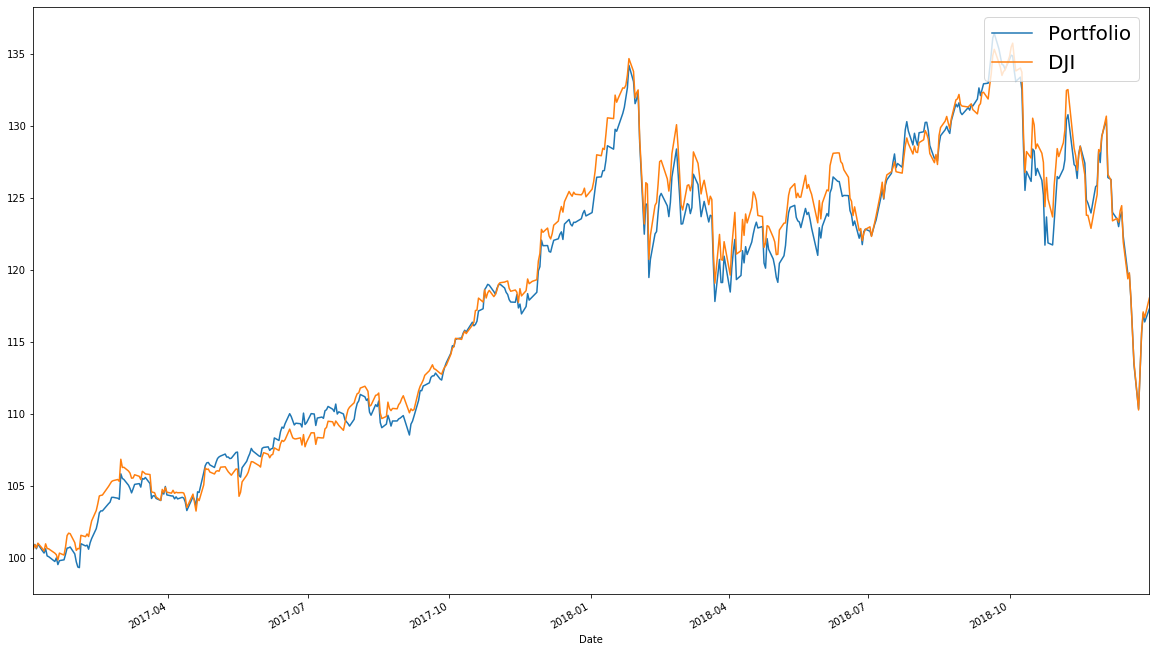

In [267]:
visual(ret, tracked_stocks, optimal_weights, 'DJI', '2017-01-01','2018-12-31')

In [298]:
forward_te = tracking_error_gen(ret, tracked_stocks, optimal_weights, 'DJI', '2019-01-01', '2019-12-31')

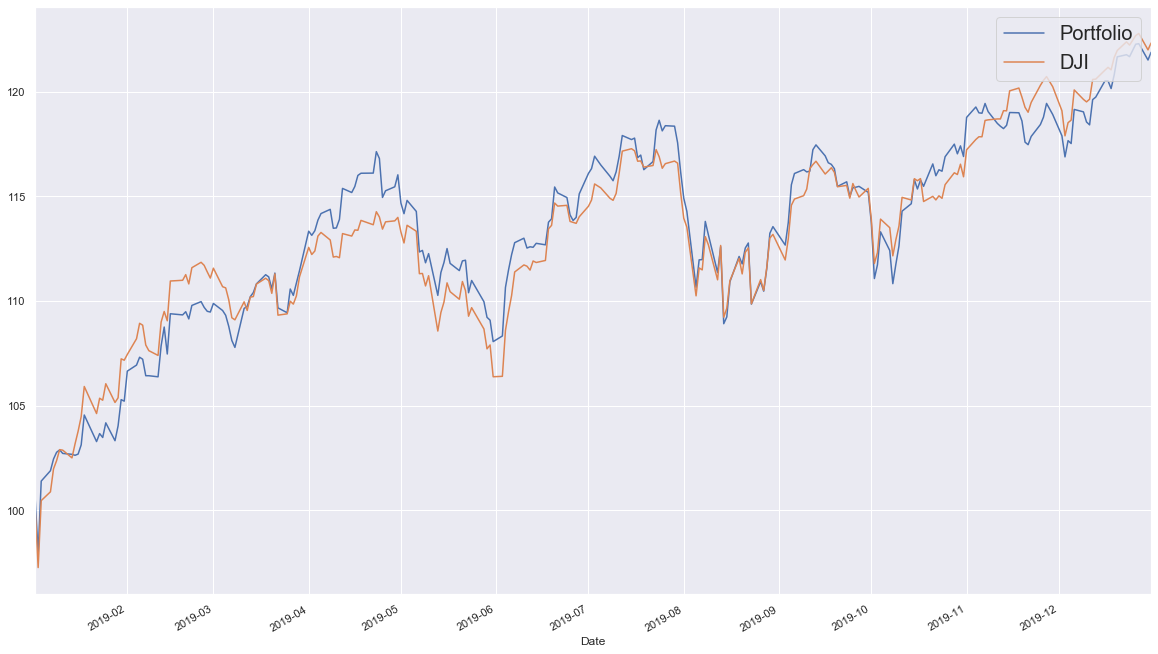

In [271]:
sns.set()
visual(ret, tracked_stocks, optimal_weights, 'DJI', '2019-01-01', '2019-12-31')

## Forward Testing (Part 2)

In [276]:
bucket = df.columns.drop(['DJI', 'DOW'])

In [288]:
random_choices = np.random.choice(bucket, size = 10, replace = False)
list(random_choices)

['KO', 'V', 'RTX', 'MRK', 'CSCO', 'CVX', 'VZ', 'WBA', 'GS', 'INTC']

In [285]:
random_numbers = np.random.random(10)
random_weights = random_numbers / random_numbers.sum()
random_weights

array([0.09818598, 0.00215731, 0.00084396, 0.26448684, 0.09509297,
       0.24407314, 0.00616826, 0.06496774, 0.17858126, 0.04544254])

In [295]:
tracking_error_gen(ret, list(random_choices), random_weights, 'DJI', '2019-01-01','2019-12-31')

0.06955648992605934

In [296]:
errors = []
for i in range(1000):
    random_choices = np.random.choice(bucket, size = 10, replace = False)
    random_numbers = np.random.random(10)
    random_weights = random_numbers / random_numbers.sum()
    errors.append(tracking_error_gen(ret, list(random_choices), random_weights, 'DJI', '2019-01-01','2019-12-31'))

In [301]:
np.mean(errors < forward_te)

0.073

(array([ 3.,  2.,  6., 11., 29., 30., 51., 56., 72., 84., 98., 81., 77.,
        64., 78., 56., 43., 46., 29., 24., 13., 21.,  8.,  5.,  3.,  2.,
         1.,  2.,  0.,  3.,  1.,  1.]),
 array([0.03795831, 0.03968063, 0.04140294, 0.04312525, 0.04484757,
        0.04656988, 0.04829219, 0.05001451, 0.05173682, 0.05345913,
        0.05518145, 0.05690376, 0.05862608, 0.06034839, 0.0620707 ,
        0.06379302, 0.06551533, 0.06723764, 0.06895996, 0.07068227,
        0.07240458, 0.0741269 , 0.07584921, 0.07757152, 0.07929384,
        0.08101615, 0.08273846, 0.08446078, 0.08618309, 0.0879054 ,
        0.08962772, 0.09135003, 0.09307234]),
 <a list of 32 Patch objects>)

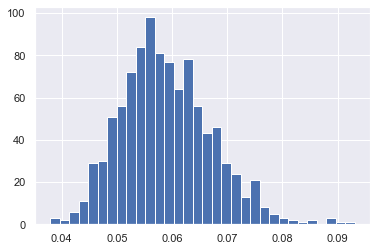

In [309]:
b = int(round(np.sqrt(len(errors))))
plt.hist(errors, bins = b)